<a href="https://colab.research.google.com/github/juanmadlg/K-armed-Bandit-Problem/blob/main/K_Armed_Testbed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### K-armed Testbed

"*The multi-armed bandit problem (sometimes called the K-armed or N-armed bandit problem) is a problem in which a fixed limited set of resources must be allocated between competing (alternative) choices in a way that maximizes their expected gain, when each choice's properties are only partially known at the time of allocation, and may become better understood as time passes or by allocating resources to the choice. This is a classic reinforcement learning problem that exemplifies the exploration–exploitation tradeoff dilemma.*"

--- [Wikipedia](https://en.wikipedia.org/wiki/Multi-armed_bandit) 


The K-armed Testbed is almost the 'Hello World' of Reinforcement Learning.

Let's implemented it.

**Note:** This Notebook has been created in Google Colab.

## Packages

You will use the following packages in this assignment.

- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [jdc](https://alexhagen.github.io/jdc/) : Jupyter magic that allows defining classes over multiple jupyter notebook cells.
- [tqdm](https://tqdm.github.io/) : A package to display progress bar when running experiments.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.

In [ ]:
!pip install jdc

In [ ]:
# Imports
import numpy as np
import jdc
from tqdm import tqdm
import matplotlib.pyplot as plt

## K-Arms Class

These are the elements included in the K-Arms Class
* **k**: The number of Arms
* **Q**: It stores the Function Values for each Arm. Vector of size (k, )
* **A**: It stores the number of 'executions' of the specific Arm. Vector of size (k, ). Initializated each time 'reset' is executed.
* **arms_mean**: Mean for the distribution of the Q* for each Arm
* **standard_deviation**: It is used in two cases: 
  * To generate the random distribution of the Q* for each Arm 
  * To generate the random value of an Arm when it is executed (using the on the Q* of the arm as a mean).
* **e**: Epsilon for action selection

In [ ]:
class k_armed:
  def __init__(self, configuration):
    '''
    Configuration is a dictionary that includes all diferente required settings
    '''
    self.Q = None
    self.N = None
    self.A = None
    self.k = configuration['k'] # Number of Arms
    self.e = configuration['e']

    self.arms_mean = configuration['arms_mean']
    self.standard_deviation = configuration['std_dev'] # For Arms Distribution and Arms values

  def reset(self):
    '''
    Reset is executed at the begining of each episode. It sets to 0 Q and N
    and creates a new distribution of Q* for the k arms.
    '''
    self.Q = np.zeros((self.k,))
    self.N = np.zeros((self.k,))
    self.A = np.random.normal(loc=self.arms_mean, scale=self.standard_deviation, size=(self.k,))

### Episilon-greedy action selection

A simple method to balance exploration and exploitation

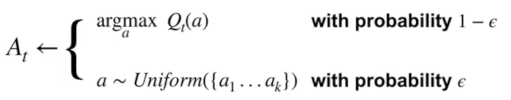


In [ ]:
%%add_to k_armed

def get_action(self):
  '''
  €-greedy action selection: exploration vs. exploitation
  '''
    
  if np.random.random_sample() <= self.e:
    return np.random.randint(self.k) # Exploration

  return np.argmax(self.Q) # Exploitation

### Bandit

Returns a random value in a normal distribution with Q*(arm) and the standard_deviation

In [ ]:
%%add_to k_armed

def bandit(self, a):
  '''
  Gets value of the selected arm based on a normal distribution with Q*(a) as the mean
  '''
  return np.random.normal(self.A[a], self.standard_deviation)

### k-armed Execution

For each step:
* Get the Action (Arm) (€-greedy action selection)
* Get the Value (Reward) for that Arm
* Increment the number of Steps
* Calculate the Value Function for the Arm: Qn+1 = Qn + (Rn - Qn) / n  

In [ ]:
%%add_to k_armed

def exec(self, steps):
  self.reset()

  rewards = []
  for i in range(steps):
    A = self.get_action()
    R = self.bandit(A)

    self.N[A] += 1
    self.Q[A] = self.Q[A] + (R - self.Q[A]) / self.N[A] # Update Value Function Q(a)

    rewards.append(R)

  return rewards

## Evaluate the Rewards

### First Scenario

* **Arms**: 10 (k)
* **Epislon**: 0.1
* **Steps**: 800


In [ ]:
configuration = {
    'k': 10,
    'e': 0.1,
    'arms_mean': 1,
    'std_dev': 1
}

steps = 800

In [ ]:
# Execute and get the rewards
rewards = k_armed(configuration).exec(steps)

Lets visualize the Rewards:

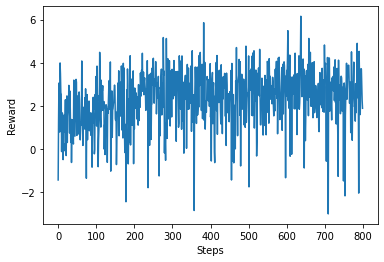

In [ ]:
plt.figure()
plt.plot(range(steps), rewards)
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.show()

### Evaluate different epsilon values

We cannot evaluate the diference only with an execution for each epsilon value. The curve is too noisy.

To evaluate the different values of epsilon we are going to execute N different runs an calculate the average for each step.

In [ ]:
def evaluate(configuration, epsilon_values, steps, runs):
  rewards = []

  # For these three epsilon values
  for epsilon in epsilon_values:
    print(f'Execution {runs} runs with epsilon {epsilon}')
    configuration['e'] = epsilon

    e_k_armed = k_armed(configuration)
    epsilon_rewards = np.zeros((steps, ))

    # Lets execute son independent runs
    for _ in range(runs):
      epsilon_rewards = np.add(epsilon_rewards, e_k_armed.exec(steps))

    # Average for each step
    rewards.append(epsilon_rewards / runs)

  return rewards

In [ ]:
epsilon_values = [0.01, 0.1, 0.5]

configuration = {
    'k': 10,
    'e': None,
    'arms_mean': 1,
    'std_dev': 1
}

steps = 800
runs = 2000

rewards = evaluate(configuration, epsilon_values, steps, runs)

Execution 2000 runs with epsilon 0.01
Execution 2000 runs with epsilon 0.1
Execution 2000 runs with epsilon 0.5


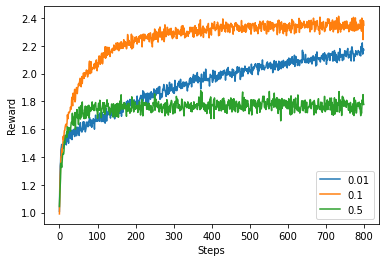

In [ ]:
plt.figure()
plt.plot(range(steps), rewards[0], label='0.01')
plt.plot(range(steps), rewards[1], label='0.1')
plt.plot(range(steps), rewards[2], label='0.5')
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.show()

**Conclusions**

We can see the different performances for the different epsilon values:

* **epsilon = 0.01**: In this case there is very little exploration and a lot of exploitation. This makes the average reward grow very little by little. What would happen if the number of steps is greater than 800?
* **epsilon = 0.1**: This seems to be the value of epsilon with better performance. It gets faster a good average reward and it maintains it. There is a good balance between exploration and exploitation for 800 Steps.
* **epsilon = 0.5**: In this case, we can see clearly that there is too much exploration. The result is clearly the worst when you explore/exploit the 50% of the time.

### Evaluate more Steps

Let's evaluate the same epsilon values with more steps. Will epsilon 0.01 be better than 0.1 in the long term?

In [ ]:
epsilon_values = [0.01, 0.1, 0.5]

configuration = {
    'k': 10,
    'e': None,
    'arms_mean': 1,
    'std_dev': 1
}

steps = 2000
runs = 2000

rewards = evaluate(configuration, epsilon_values, steps, runs)

Execution 2000 runs with epsilon 0.01
Execution 2000 runs with epsilon 0.1
Execution 2000 runs with epsilon 0.5


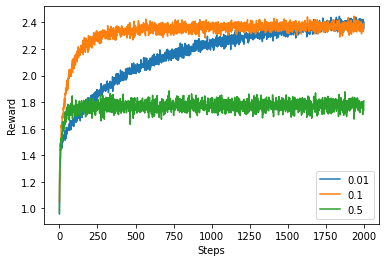

In [ ]:
plt.figure()
plt.plot(range(steps), rewards[0], label='0.01')
plt.plot(range(steps), rewards[1], label='0.1')
plt.plot(range(steps), rewards[2], label='0.5')
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.legend()
plt.show()

Finally, it seems that 0.01 and 0.1 epsilon values converge to the same average reward. So 0.1 is better due to it does faster.